# Image Patches

We would like to remove patches from images and have a network learn how to fill in these missing patches. 

## Copy an Image from Input to Output

To start, let's just build a network that takes and image as an input and generates the same image at the output.

In [1]:
import os
import json

import numpy as np

from fastai2.basics import DataBlock, RandomSplitter

from fastai2.vision.all import ImageBlock, PILMask, get_image_files
from fastai2.vision.core import get_annotations, Image, TensorBBox, TensorPoint, TensorImage
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform
from fastai2.vision.learner import unet_learner, unet_config

from fastai2.data.external import download_url, URLs, untar_data

from torch.nn import MSELoss
from torchvision.models import resnet34

### Get Data: PascalVOC

In [2]:
pascal_path = untar_data(URLs.PASCAL_2012)
pascal_path

Path('/home/josh/.fastai/data/pascal_2012')

In [21]:
# Let's only work with some of the images so we can speed things up
def first_thousand_images(path):
    img_files = get_image_files(path)[:1000]
    return img_files

In [22]:
data = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=first_thousand_images,
                   splitter=RandomSplitter(),
                   get_y=lambda o: o)

In [23]:
databunch = data.databunch(pascal_path/'train', 
                           bs=8, 
                           item_tfms=RandomResizedCrop(460, min_scale=0.75), 
                           batch_tfms=[*aug_transforms(size=224, max_warp=0)])
# HACK: We're predicting pixel values, so we're just going to predict an output for each RGB channel
databunch.vocab = ['R', 'G', 'B']


Let's look at the images. On the left are input images, and on the right is the image we would like to generate.

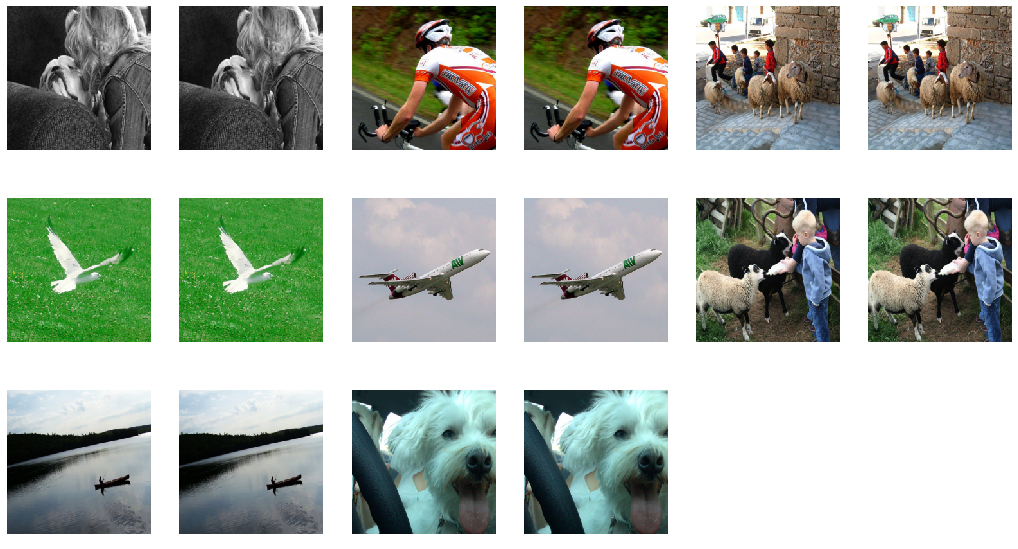

In [6]:
databunch.show_batch(max_n=9)

In [7]:
loss = MSELoss()
learn = unet_learner(databunch, resnet34, config=unet_config(), loss_func=loss)

epoch,train_loss,valid_loss,time
0,0.684236,0.693787,00:27


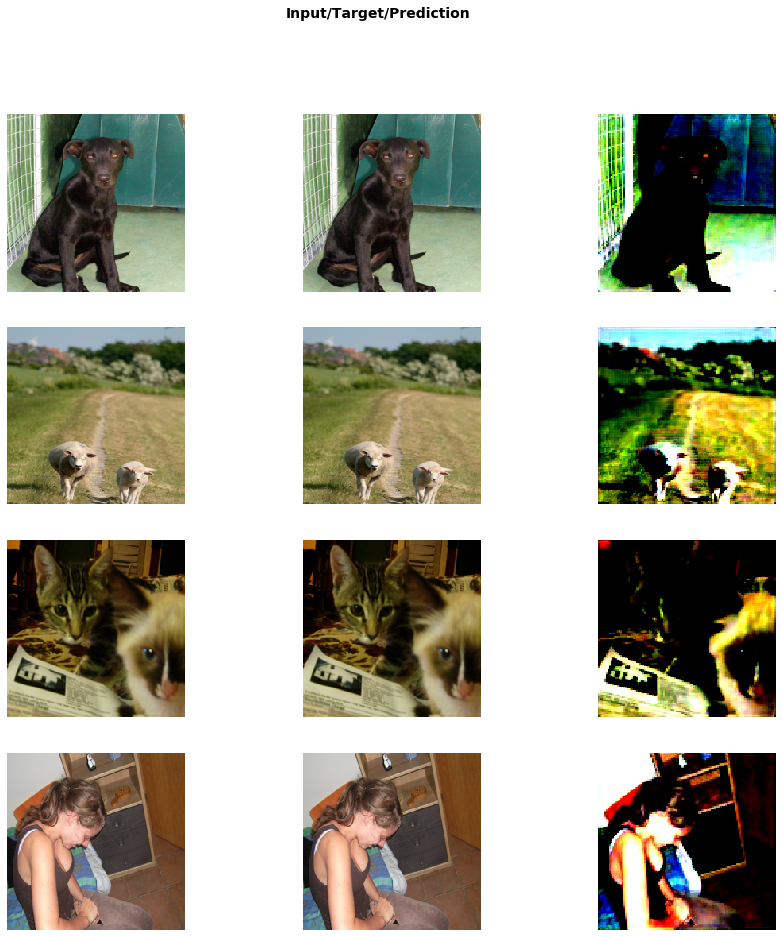

In [8]:
# To get a sense of the task, let's just use a small learning rate and 1 epoch
# That way we'll be able to see the output before the model becomes perfect at this task
learn.fit_one_cycle(1, 1e-3)
learn.predict(databunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))

We can see the network has started to learn to output similar images, but needs a litle bit more time (or a higher learning rate).

epoch,train_loss,valid_loss,time
0,0.255641,0.064091,00:22
1,0.040451,0.002322,00:22
2,0.008939,0.001342,00:23


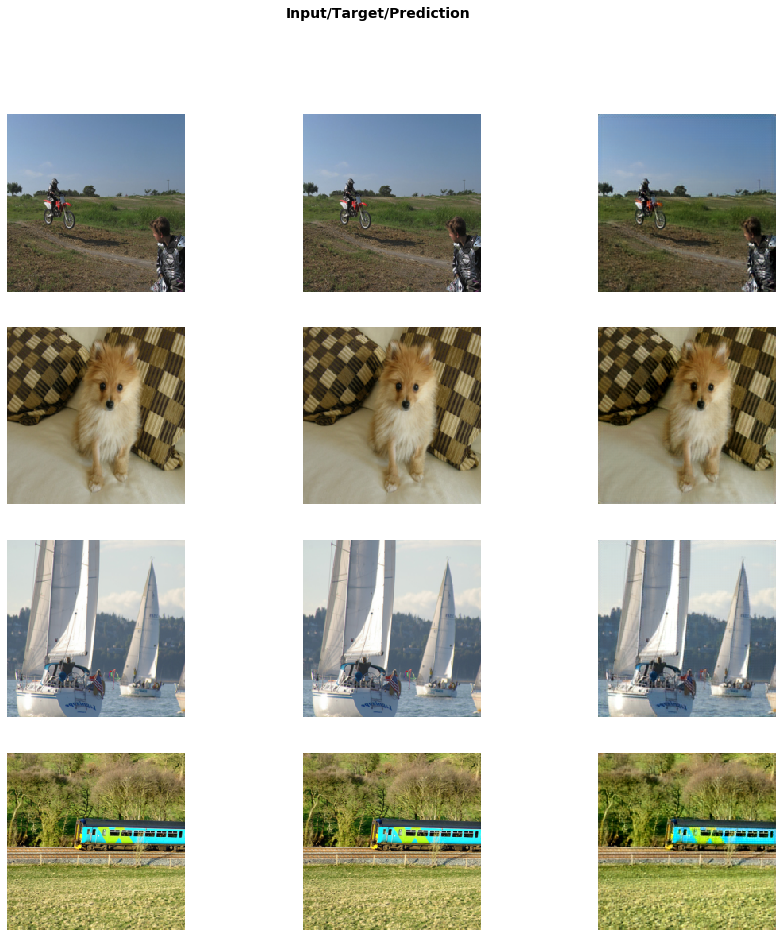

In [9]:
learn.fit_one_cycle(3, 1e-2)
learn.predict(databunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))

Now it works pretty well!

## Image Patches

Now that we can copy images from the input to the output, let's start removing pieces of them and see if our network can learn to fill in the missing parts

In [12]:
class RandomCutout(RandTransform):
    "Picks a random scaled crop of an image and resize it to `size`"
    split_idx = None
    def __init__(self, min_n_holes=5, max_n_holes=10, min_length=5, max_length=150, **kwargs):
        super().__init__(**kwargs)
        self.min_n_holes=min_n_holes
        self.max_n_holes=max_n_holes
        self.min_length=min_length
        self.max_length=max_length

    def encodes(self, x:Image.Image):
        
        n_holes = np.random.randint(self.min_n_holes, self.max_n_holes)
        pixels = np.array(x) # Convert to mutable numpy array. FeelsBadMan
        h,w = pixels.shape[:2]

        for n in range(n_holes):
            h_length = np.random.randint(self.min_length, self.max_length)
            w_length = np.random.randint(self.min_length, self.max_length)
            h_y = np.random.randint(0, h)
            h_x = np.random.randint(0, w)
            y1 = int(np.clip(h_y - h_length / 2, 0, h))
            y2 = int(np.clip(h_y + h_length / 2, 0, h))
            x1 = int(np.clip(h_x - w_length / 2, 0, w))
            x2 = int(np.clip(h_x + w_length / 2, 0, w))
           
            pixels[y1:y2, x1:x2, :] = 0
            
        return Image.fromarray(pixels, mode='RGB')

In [24]:
databunch = data.databunch(pascal_path/'train', 
                           bs=8, 
                           item_tfms=[RandomResizedCrop(460, min_scale=0.75), RandomCutout()], 
                           batch_tfms=[*aug_transforms(size=224, max_warp=0, max_rotate=0)])
# HACK: We're predicting pixel values, so we're just going to predict an output for each RGB channel
databunch.vocab = ['R', 'G', 'B']

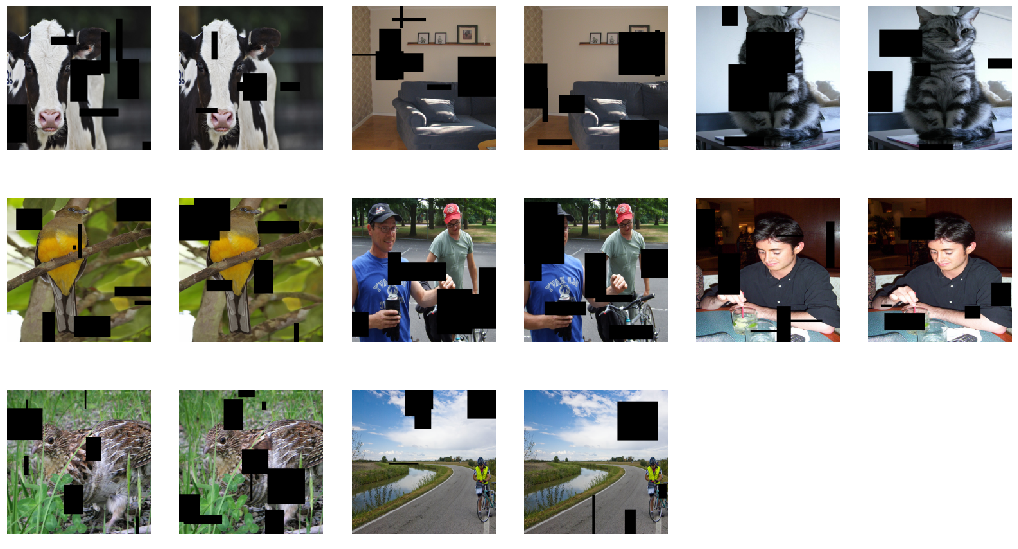

In [17]:
# TODO: We need to apply RandomCutout ONLY to our input images (X).
# As shown below, it's currently applied to both the input and output.
databunch.show_batch(max_n=9)

In [15]:
#TODO: 
loss = MSELoss()
learn = unet_learner(databunch, resnet34, config=unet_config(), loss_func=loss)

In [ ]:
#TODO:
learn.fit_one_cycle(5, 1e-3)
learn.predict(databunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))